In [70]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

import pandas as pd
from tqdm import tqdm, trange
import os

In [71]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

learning_rate = 1e-3
epochs = 20

In [72]:
# download cifar10 dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomAffine(degrees=(-10, 10)),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, n_classes):
        super(CIFAR10Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [74]:
model = CIFAR10Classifier(n_classes=10)
item = test_data[0][0].unsqueeze(0)
items, labels = zip(*test_data)
test_images = torch.stack(items)
test_images.size()

torch.Size([10000, 3, 32, 32])

In [75]:
meta_classes = {
    0: 0,
    1: 0,
    2: 1,
    3: 2,
    4: 1,
    5: 2,
    6: 1,
    7: 1,    
    8: 0,
    9: 0,
}

targets = train_data.targets
meta_targets = [meta_classes[t] for t in targets]


# Calculate class counts
class_counts = torch.bincount(torch.tensor(meta_targets))
class_weights = 1.0 / class_counts.float()

# Assign weights to each sample
sample_weights = [class_weights[meta_target] for meta_target in meta_targets]

# Create a sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(meta_targets), replacement=True)

# DataLoader with the sampler
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

In [76]:
model_meta = CIFAR10Classifier(n_classes=3)
model_meta.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta.parameters(), lr=learning_rate)

for epoch in trange(epochs):
    for images, labels in train_loader:
        meta_labels = torch.tensor([meta_classes[l.item()] for l in labels]).to(DEVICE)
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_meta(images)
        loss = criterion(outputs, meta_labels)
        loss.backward()
        optimizer.step()


100%|██████████| 20/20 [09:46<00:00, 29.33s/it]


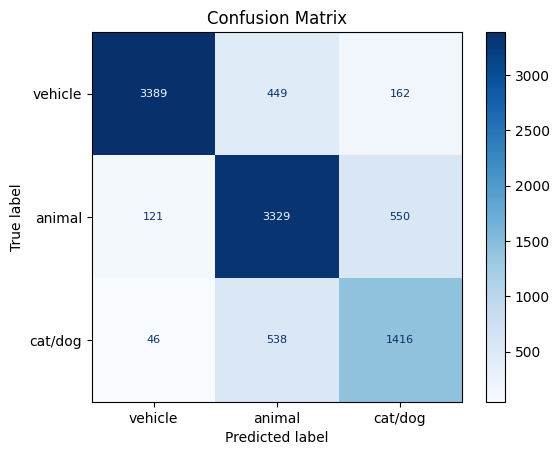

0.8134

In [77]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def confusion_matri_plotter(y_true, y_pred, classes):
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    disp.plot(cmap=plt.cm.Blues, 
            text_kw={'fontsize': 8, 'ha': 'center', 'va': 'center'})

    # Format numbers as integers without scientific notation
    for text in disp.text_.ravel():
        text.set_text(f'{int(float(text.get_text()))}')

    plt.title('Confusion Matrix')
    plt.show()

classes = ('vehicle', 'animal', 'cat/dog')
test_meta_targets = [meta_classes[t] for t in test_data.targets]
predicted_test_targets = model_meta(test_images.to(DEVICE)).argmax(dim=1).cpu()

confusion_matri_plotter(test_meta_targets, predicted_test_targets, classes)
accuracy_score(test_meta_targets, predicted_test_targets)

In [78]:
model_general = CIFAR10Classifier(n_classes=10)
model_general.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_general.parameters(), lr=learning_rate)
train_loader = DataLoader(train_data, batch_size=64)

for epoch in trange(epochs):
    for images, labels in train_loader:
        labels = labels.to(DEVICE)
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_general(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


100%|██████████| 20/20 [10:16<00:00, 30.83s/it]


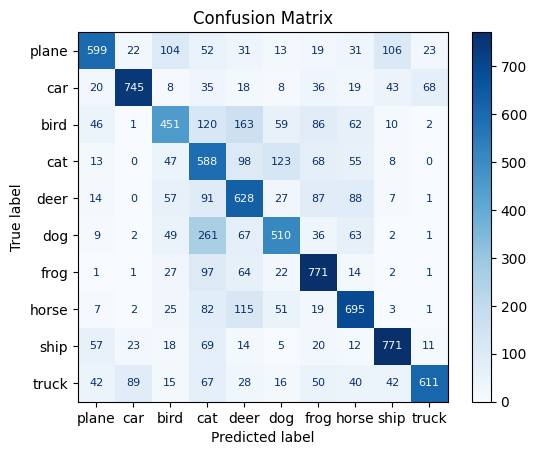

0.6369

In [79]:
# confusion Matrix
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
test_targets = test_data.targets
predicted_test_targets = model_general(test_images.to(DEVICE)).argmax(dim=1).cpu()

confusion_matri_plotter(test_targets, predicted_test_targets, classes)
accuracy_score(test_targets, predicted_test_targets)

In [80]:
meta_class_0_subclasses = {
    0: 1,
    1: 2,   
    8: 3,
    9: 4,
}

meta_targets = [meta_class_0_subclasses.get(t,0) for t in targets]

# Calculate class counts
class_counts = torch.bincount(torch.tensor(meta_targets))
class_weights = 1.0 / class_counts.float()

# Assign weights to each sample
sample_weights = [class_weights[meta_target] for meta_target in meta_targets]

# Create a sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(meta_targets), replacement=True)

# DataLoader with the sampler
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

In [81]:
model_meta_class_0 = CIFAR10Classifier(n_classes=5)
model_meta_class_0.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta_class_0.parameters(), lr=learning_rate)

for epoch in trange(epochs):
    for images, labels in train_loader:
        labels = torch.tensor([meta_class_0_subclasses.get(l.item(), 0) for l in labels]).to(DEVICE)
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_meta_class_0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [10:45<00:00, 32.26s/it]


In [82]:
meta_class_1_subclasses = {
    2: 1,
    4: 2,
    6: 3,
    7: 4,
}

meta_targets = [meta_class_1_subclasses.get(t,0) for t in targets]


# Calculate class counts
class_counts = torch.bincount(torch.tensor(meta_targets))
class_weights = 1.0 / class_counts.float()

# Assign weights to each sample
sample_weights = [class_weights[meta_target] for meta_target in meta_targets]

# Create a sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(meta_targets), replacement=True)

# DataLoader with the sampler
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

In [83]:
model_meta_class_1 = CIFAR10Classifier(n_classes=5)
model_meta_class_1.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta_class_1.parameters(), lr=learning_rate)

for epoch in trange(epochs):
    for images, labels in train_loader:
        labels = torch.tensor([meta_class_1_subclasses.get(l.item(), 0) for l in labels]).to(DEVICE)
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_meta_class_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [10:23<00:00, 31.17s/it]


In [84]:
meta_class_2_subclasses = {
    3: 1,
    5: 2,
}

meta_targets = [meta_class_2_subclasses.get(t,0) for t in targets]


# Calculate class counts
class_counts = torch.bincount(torch.tensor(meta_targets))
class_weights = 1.0 / class_counts.float()

# Assign weights to each sample
sample_weights = [class_weights[meta_target] for meta_target in meta_targets]

# Create a sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(meta_targets), replacement=True)

# DataLoader with the sampler
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

In [85]:
model_meta_class_2 = CIFAR10Classifier(n_classes=3)
model_meta_class_2.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta_class_2.parameters(), lr=learning_rate)

for epoch in trange(epochs):
    for images, labels in train_loader:
        labels = torch.tensor([meta_class_2_subclasses.get(l.item(), 0) for l in labels]).to(DEVICE)
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_meta_class_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [10:08<00:00, 30.42s/it]


Incorrect predictions: 663


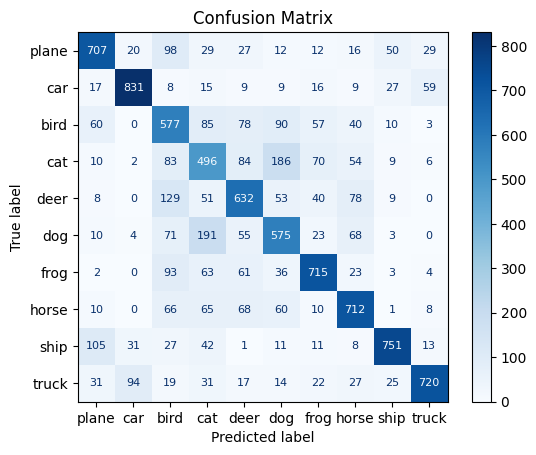

0.6716

In [86]:
def stacked_predictions(meta_model, sub_models, general_model, input_images, sub_prediction_maps):
    assert len(sub_models) == len(sub_prediction_maps)
    
    
    # eval mode
    meta_model.eval()
    general_model.eval()
    
    for submodel in sub_models:
        submodel.eval()
    
    # predictions
    with torch.no_grad():
        
        # metaclass
        meta_features = meta_model(input_images).argmax(dim=1)
        predictions = torch.zeros_like(meta_features)
        
        # predict subclasses
        for k, submodel in enumerate(sub_models):
            mask = meta_features == k
            sub_prediction = submodel(input_images[mask]).argmax(dim=1)
            
            prediction_map = sub_prediction_maps[k]
            predictions[mask] = torch.tensor([prediction_map.get(pred.item(), -1) for pred in sub_prediction], device=DEVICE)
            
        incorrect_mask = predictions == -1
        print(f"Incorrect predictions: {incorrect_mask.sum().item()}")
        predictions[incorrect_mask] = general_model(input_images[incorrect_mask]).argmax(dim=1)
        
    return predictions.cpu()


sub_predictions_maps = [
    {1:0, 2:1, 3:8, 4:9},
    {1:2, 2:4, 3:6, 4:7},
    {1:3, 2:5}, 
]

sub_models = [
    model_meta_class_0, 
    model_meta_class_1, 
    model_meta_class_2,
]

predictions = stacked_predictions(model_meta, sub_models, model_general, test_images.to(DEVICE), sub_predictions_maps)
confusion_matri_plotter(test_targets, predictions, classes)
accuracy_score(test_targets, predictions)

In [87]:
test_images.to(DEVICE)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ..., -0.0588,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0039,  0.0000,  0.0000],
          [ 0.2941,  0.3020,  0.2549,  ...,  0.0118,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000, -0.6078,  ..., -0.3020, -0.6235, -0.8118],
          [ 0.0000,  0.0000, -0.6078,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.4667,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ..., -0.3020,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2627,  0.0000,  0.0000],
          [-0.0902, -0.0745, -0.1216,  ..., -0.2706,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000, -0.1373,  ...,  0.0588, -0.2235, -0.3961],
          [ 0.0000,  0.0000, -0.1529,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000, -0.0275,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ..., -0.7412,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [90]:
# Save the models

torch.save(model_general.state_dict(), 'models2/model_general.pth')
torch.save(model_meta.state_dict(), 'models2/model_meta.pth')
torch.save(model_meta_class_0.state_dict(), 'models2/model_meta_class_0.pth')
torch.save(model_meta_class_1.state_dict(), 'models2/model_meta_class_1.pth')
torch.save(model_meta_class_2.state_dict(), 'models2/model_meta_class_2.pth')


In [91]:
# load models
loaded_model_general = CIFAR10Classifier(10)
loaded_model_general.load_state_dict(torch.load('models2/model_general.pth', weights_only=False))
loaded_model_general

CIFAR10Classifier(
  (layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=256, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=10, bias=True)
  )
)